## Imports

In [166]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

from dataset import MultiModalDataset

## Function for saving videos

In [167]:
"""Function to save videos in ./outputs.

Args:
    video_tensor (Tensor): The video tensor in BNCTHW format.
    index (int): The video index in the batch. Default: 0.
"""
def output_video(video_tensor, index=0):
    os.makedirs('output', exist_ok=True)
    for i, np_image in enumerate(video_tensor[index].squeeze().permute(1,2,3,0)):
        print(np_image.shape)
        img_array = np.array(np_image.numpy())
        plt.imshow(img_array)
        plt.axis('off')  # Turn off axis labels and ticks

        # Save the image using plt.savefig()
        output_path = f"output/{i}.jpg"
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)

## Loading batches

In [168]:
dataset = MultiModalDataset(ann_file='../../data/something-something-v2/train_annotations.txt',
                            root_dir='../../data/something-something-v2/rawframes',
                            clip_len=32,
                            resolution=(240, 427),
                            modalities=('rgb'),
                            test_mode=False,
                            frame_interval=1,
                            input_resolution=(240, 427),
                            num_clips=1
                            )

In [169]:
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                                batch_size=2,
                                                shuffle=True,
                                                num_workers=4,
                                                pin_memory=True)

In [170]:
iter_ = iter(train_loader)

/Users/sadat/miniconda3/envs/scrambmix/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/Users/sadat/miniconda3/envs/scrambmix/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/Users/sadat/miniconda3/envs/scrambmix/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning:

In [171]:
result = next(iter_)
imgs = result['rgb'].unsqueeze(dim=1)
label = result['label'].unsqueeze(dim=1)
imgs.shape

torch.Size([2, 1, 3, 32, 240, 427])

## Apply the MixUp method

In [172]:
imgs.shape

torch.Size([2, 1, 3, 32, 240, 427])

In [173]:
from mmaction.datasets import CutmixBlending

mixup = CutmixBlending(num_classes=174, alpha=5)

mixup_out = mixup.do_blending(imgs, label)

In [174]:
imgs = mixup_out[0]
labels = mixup_out[1]

In [175]:
# output_video(imgs)

## Separate the Model

In [176]:
model = torch.load('./csn_ssv2_baseline_58e.pth',map_location=torch.device('cpu'))

In [177]:
backbone = dict()
head = dict()

checkpoint = model['state_dict']

In [178]:
for key in checkpoint.keys():
    if key[:9] == 'backbone.':
        backbone[key[9:]] = checkpoint[key]
    else:
        head[key[9:]] = checkpoint[key]

In [179]:
torch.save(backbone, '../../backbone.pth')
torch.save(head, '../../head.pth')

## Model

In [180]:
from mmaction.models import ResNet3dCSN

In [181]:
backbone = ResNet3dCSN(
        pretrained2d=False,
        out_indices=(0, 1, 2, 3),
        pretrained='https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r50_ig65m_20210617-ce545a37.pth',
        depth=50,
        with_pool2=False,
        bottleneck_mode='ir',
        norm_eval=True,
        zero_init_residual=False,
        bn_frozen=True,)

In [182]:
backbone.load_state_dict(torch.load('../../backbone.pth'))

<All keys matched successfully>

In [183]:
from mmaction.models import I3DHead

head =  I3DHead(
        num_classes=174,
        in_channels=2048,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01)

In [184]:
head.load_state_dict(torch.load('../../head.pth'))

<All keys matched successfully>

## Getting the activations

In [185]:
backbone.eval()
head.eval()

I3DHead(
  (loss_cls): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_cls): Linear(in_features=2048, out_features=174, bias=True)
  (avg_pool): AdaptiveAvgPool3d(output_size=(1, 1, 1))
)

In [186]:
label_ix = 0

In [187]:
layer_outputs = backbone(imgs[label_ix])
len(layer_outputs)

4

In [188]:
last_layer = layer_outputs[3].squeeze()
last_layer.shape

torch.Size([2048, 4, 8, 14])

In [189]:
# Get the head weights
head_weights = head.fc_cls.weight
head_weights.shape

torch.Size([174, 2048])

In [190]:
class_num = label[label_ix].item()
class_num

109

In [191]:
class_scores = torch.matmul(head_weights, last_layer.view(2048, -1))
class_scores = class_scores.view(174, 4, 8, 14)

In [192]:
class_scores.shape

torch.Size([174, 4, 8, 14])

In [193]:
cam = class_scores[class_num] # Set the class

In [194]:
cam.shape

torch.Size([4, 8, 14])

In [195]:
import torch.nn as nn
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter

In [196]:
# Upsample the CAM to match the size of the original activation map
upsampled_tensor = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(32, 240, 427), mode='trilinear')

In [197]:
upsampled_tensor.shape

torch.Size([1, 1, 32, 240, 427])

## Saving the CAM

In [198]:
smoothed_cam = upsampled_tensor

In [199]:
# Normalize the CAM values between 0 and 1
normalized_cam = (smoothed_cam - smoothed_cam.min()) / (smoothed_cam.max() - smoothed_cam.min())

# Convert the normalized CAM to a numpy array and remove singleton dimensions
normalized_cam_np = normalized_cam.squeeze()

# Choose a colormap (e.g., 'jet')
colormap = plt.get_cmap('jet')

# Map normalized CAM values to colors using the chosen colormap
colored_cam_np = colormap(normalized_cam_np.detach().numpy().squeeze())[:, :, :, :3] 
colored_cam_np.shape

(32, 240, 427, 3)

In [200]:
colored_cam = torch.from_numpy(colored_cam_np).permute(3, 0, 1, 2).unsqueeze(0).unsqueeze(0)
colored_cam.shape

torch.Size([1, 1, 3, 32, 240, 427])

In [201]:
imgs.shape

torch.Size([2, 1, 3, 32, 240, 427])

In [202]:
overlayed_video = imgs.clone()
overlayed_video[:,:,:,:,:,:] = imgs[:,:,:,:,:,:] + 0.8 * colored_cam
overlayed_video.shape

torch.Size([2, 1, 3, 32, 240, 427])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])
torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([240, 427, 3])


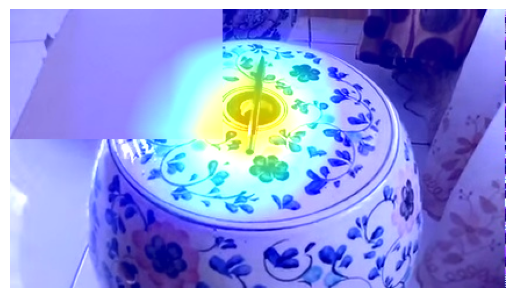

In [203]:
output_video(overlayed_video)